In [23]:
import pandas as pd
import numpy as np

### Loading the feature functions from CSV and trimming

In [24]:
df = pd.read_csv("features/ff_all.csv")

# Save to a CSV file
molecules = df['Mol'].values


molecules = molecules
molecules

array(['LiH', 'NaH', 'KH', 'RbH', 'CsH', 'CsCl', 'LiCl', 'CuI', 'LiF'],
      dtype=object)

### Size Modification and adding parameters to Data Frame

In [25]:
df

,Mol,Pol_C,Pol_A,RadV_C,RadV_A,CN_C,CN_A,Ion_C,Ion_A,EA_C,EA_A,EN_C,EN_A,RadI_A,RadI_C
0,LiH,164.1,4.51,182,120,6,6,5.392,13.590,0.754,0.618,0.98,2.20,60,150
1,NaH,162.7,4.51,227,120,6,6,5.139,13.590,0.754,0.548,0.93,2.20,95,150
2,KH,289.7,4.51,275,120,6,6,4.341,13.590,0.754,0.501,0.82,2.20,133,150
3,RbH,319.8,4.51,303,120,6,6,4.177,13.590,0.754,0.468,0.82,2.20,148,150
4,CsH,400.6,4.51,343,120,6,6,3.849,13.590,0.754,0.472,0.79,2.20,169,150
5,CsCl,400.6,14.60,343,175,8,8,3.849,12.960,3.617,0.472,0.79,3.16,169,181
6,LiCl,164.1,14.60,120,175,6,6,5.392,12.960,3.617,0.618,2.20,3.16,60,181
7,CuI,46.5,32.90,140,198,4,4,7.726,10.451,3.059,1.228,1.90,2.66,74,216
8,LiF,164.1,3.74,120,135,6,6,5.392,17.423,3.339,0.618,2.20,3.98,60,136


In [26]:
df = df.iloc[:9,0:]

df['Sum_EN'] = df['EN_C'] + df['EN_A']
df['Diff_EN'] = df['EN_A'] - df['EN_C']
# # df['Diff_rad'] = df['RadV_A'] - df['RadV_C']
df['Sum_ea'] = df['EA_C'] + df['EA_A']
df['Diff_ea'] = df['EA_C'] - df['EA_A']

df['Abs_diff_ea'] = abs(df['EA_C'] - df['EA_A'])

df['Sum_ion'] = df['Ion_C'] + df['Ion_A']
df['Diff_ion'] = df['Ion_C'] - df['Ion_A']
df['Abs_diff_ion'] = abs(df['Ion_C'] - df['Ion_A'])

df['Sum_rad'] = df['RadV_C'] + df['RadV_A']
df['Diff_rad'] = df['RadV_C'] - df['RadV_A']
df['Abs_diff_rad'] = abs(df['RadV_C'] - df['RadV_A'])

df['Sum_ion_rad'] =df['RadI_C'] + df['RadI_A']




# # Adding sqrt values for each column
# for col in df.columns:
#     # Make sure the column is numeric before applying sqrt
#     if pd.api.types.is_numeric_dtype(df[col]):
#         df[f'{col}_sqrt'] = np.sqrt(abs(df[col]))
#         df[f'{col}_squared'] = np.square(df[col])



# df['sum_ion'] = df['Ion_C'] + df['Ion_A']
# # df['diff_ion'] = df['Ion_C'] - df['Ion_A']
df.columns

Index(['Mol', 'Pol_C', 'Pol_A', 'RadV_C', 'RadV_A', 'CN_C', 'CN_A', 'Ion_C',
       'Ion_A', 'EA_C', 'EA_A', 'EN_C', 'EN_A', 'RadI_A', 'RadI_C', 'Sum_EN',
       'Diff_EN', 'Sum_ea', 'Diff_ea', 'Abs_diff_ea', 'Sum_ion', 'Diff_ion',
       'Abs_diff_ion', 'Sum_rad', 'Diff_rad', 'Abs_diff_rad', 'Sum_ion_rad'],
      dtype='object')

### making the combinations

In [6]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

In [1]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names):
    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Precompute invalid pairs (parameter and its inverse)
    invalid_pairs = {f"{name}^(-1)": name for name in param_names}
    invalid_pairs.update({name: f"{name}^(-1)" for name in param_names})

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):

            subset_names = [combined_param_names[i] for i in subset_indices]

            # Skip invalid subsets early
            if any(invalid_pairs.get(name) in subset_names for name in subset_names):
                continue

            # Select the subset DataFrame
            subset = combined_params_df[subset_names]

            # Replace NaN values with 0
            subset = subset.fillna(0)

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results


In [7]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

def process_combinations_chunk(args):
    combined_params_df, combined_param_names, param_names, indices_chunk = args
    results = []

    for indices in indices_chunk:
        subset_names = [combined_param_names[i] for i in indices]
        subset = combined_params_df[subset_names]

        # Replace NaN values with 0
        subset = subset.fillna(0)

        # Check if both a parameter and its inverse are in the subset
        invalid = False
        for name in subset_names:
            if name.endswith("^(-1)") and name[:-5] in subset_names:
                invalid = True
                break
            elif name in param_names and f"{name}^(-1)" in subset_names:
                invalid = True
                break

        if not invalid:
            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results

def generate_combinations_df_parallel(params_df, param_names):
    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Generate all subsets of parameter indices
    all_combinations = [
        indices for r in range(1, len(combined_param_names) + 1)
        for indices in itertools.combinations(range(len(combined_param_names)), r)
    ]

    # Divide all_combinations into chunks
    num_workers = min(cpu_count(), len(all_combinations))
    chunk_size = max(1, len(all_combinations) // num_workers)
    chunks = [all_combinations[i:i + chunk_size] for i in range(0, len(all_combinations), chunk_size)]

    print(f"Using {num_workers} workers to process {len(all_combinations)} combinations in {len(chunks)} chunks")

    # Prepare arguments for parallel processing
    args = [
        (combined_params_df, combined_param_names, param_names, chunk)
        for chunk in chunks
    ]

    # Use multiprocessing to process combinations in parallel
    with Pool(processes=num_workers) as pool:
        results = pool.map(process_combinations_chunk, args)

    # Flatten results
    flattened_results = [item for sublist in results for item in sublist]
    return flattened_results


In [17]:

import os
import pandas as pd

takeSaved = False

all_expressions = []
expressions = []
# Define file name to save/load the results
cache_file = "cached_expressions.pkl"

if os.path.exists(cache_file) and takeSaved:
    # Load the cached results if they exist
    expressions = pd.read_pickle(cache_file)
    all_expressions = list(expressions.itertuples(index=False, name=None))
    print("Loaded cached expressions.")
else:
    # Perform the costly computation if cache does not exist
    print("Calculating expressions...")
    param_names = list(df.iloc[:,1:12].columns)
    all_expressions = generate_combinations_df(df.iloc[:, 1:12], param_names)
    expressions = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

    # Save the results to cache
    expressions.to_pickle(cache_file)
    print("Expressions cached.")

# Print the shape of the expressions DataFrame
print(expressions.shape)


Calculating expressions...


C:\Users\user\AppData\Local\Temp\ipykernel_23756\3972913922.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)


Expressions cached.
(177146, 2)


In [18]:
expressions.head()

,Expression,Value
0,Pol_C,0 164.1 1 162.7 2 289.7 3 319.8 4 ...
1,Pol_A,0 4.51 1 4.51 2 4.51 3 4.51 4 ...
2,RadV_C,0 182 1 227 2 275 3 303 4 343 5...
3,RadV_A,0 120 1 120 2 120 3 120 4 120 5...
4,CN_C,0 6 1 6 2 6 3 6 4 6 5 8 6 ...


### Addition results to the combinations

In [19]:
%store -r res
res

[14.137466826376718,
 14.087159279098158,
 14.02702180402777,
 12.930918115689444,
 12.275605094480198,
 3.2325958680570794,
 5.11791434948661,
 3.5739198265668453,
 4.719651538728355]

In [20]:
values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)
values['res'] = res

### Finding Corelation

In [21]:

correlation = values.corr()

correlation.shape

MemoryError: Unable to allocate 234. GiB for an array with shape (177147, 177147) and data type float64

In [14]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index

res                                                                                            1.000000
RadV_A^(-1) * Ion_A^(-1)                                                                       0.962337
CN_A * RadV_A^(-1) * CN_C^(-1) * Ion_A^(-1)                                                    0.962337
CN_C * RadV_A^(-1) * CN_A^(-1) * Ion_A^(-1)                                                    0.962337
RadV_A * CN_A * Ion_A * CN_C^(-1)                                                              0.949182
RadV_A * CN_C * Ion_A * CN_A^(-1)                                                              0.949182
RadV_A * Ion_A                                                                                 0.949182
RadV_C * CN_A * Pol_C^(-1) * Pol_A^(-1) * RadV_A^(-1) * CN_C^(-1) * Ion_C^(-1) * Ion_A^(-1)    0.948614
RadV_C * CN_C * Pol_C^(-1) * Pol_A^(-1) * RadV_A^(-1) * CN_A^(-1) * Ion_C^(-1) * Ion_A^(-1)    0.948614
RadV_C * Pol_C^(-1) * Pol_A^(-1) * RadV_A^(-1) * Ion_C^(-1) * Io

### Final Results

In [93]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index


res                                                                                          1.000000
Pol_C * EN_C * EN_A * CN_C^(-1) * Ion_C^(-1) * Sum_ea^(-1)                                   0.993684
Ion_C * Ion_A * EN_C * EN_A * Sum_ea * CN_C^(-1)                                             0.993595
CN_C * Ion_C * Ion_A * Sum_ea * Pol_C^(-1) * EN_C^(-1) * EN_A^(-1)                           0.992235
CN_C * Ion_C * Sum_ea * Pol_C^(-1) * EN_C^(-1) * EN_A^(-1)                                   0.991912
CN_C * Ion_C * EN_C^(-1) * EN_A^(-1)                                                         0.991572
Ion_C * EN_C^(-1) * EN_A^(-1)                                                                0.991381
Ion_C * Ion_A * Sum_ea * Pol_C^(-1) * EN_C^(-1) * EN_A^(-1)                                  0.991109
Ion_C * Ion_A * EN_C^(-1) * EN_A^(-1)                                                        0.991103
Ion_C * Ion_A * CN_C^(-1) * EN_C^(-1) * EN_A^(-1)                                 

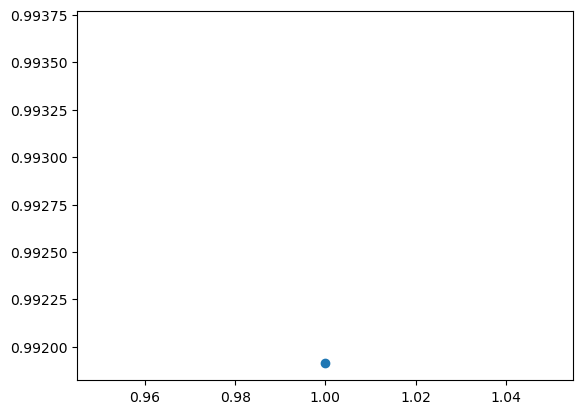

1.0


In [94]:
import matplotlib.pyplot as plt

plt.scatter(results['res'],results[top_vars[3]])
plt.plot(results['res'],results[top_vars[0]])
plt.show()

values[top_vars[0]]


# param = df['Cat_EN']*df['Ani_EN']*df['Rad_C']*df['CN']*df['Ion_C']*df['Ion_A']



# y = list(values[top_vars[0]])[:4]+list(values[top_vars[0]])[5:]
# x = list(values['res'])[:4]+list(values['res'])[5:]

# plt.scatter(x,y)
# x

print(results['res'])

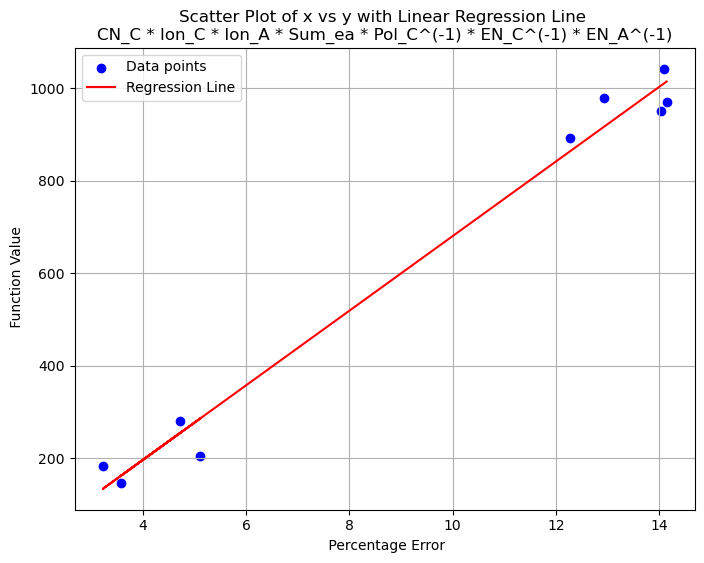

(0.9845309753043855, 2264.3182086700476, 'y = 80.7823x + -127.5399')

In [98]:
param = top_vars[2]

y = values[param]
x = values['res']

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming x and y are Pandas Series
# Reshape x to a 2D array
x_reshaped = x.values.reshape(-1, 1)  # Convert x to a 2D array (n, 1)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x_reshaped, y)

# Get the slope (coefficient) and intercept
slope = model.coef_[0]  # model.coef_ gives the slope of the line
intercept = model.intercept_  # model.intercept_ gives the intercept

# Predict y values using the linear model
y_pred = model.predict(x_reshaped)

# Plot the data points and the regression line
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_pred, color='red', label='Regression Line')
plt.title(f'Scatter Plot of x vs y with Linear Regression Line \n{param}')
plt.xlabel(' Percentage Error')
plt.ylabel(' Function Value')
plt.grid()
plt.legend()
plt.show()

# Calculate R^2 and MSE
r_squared = r2_score(y, y_pred)
msd = mean_squared_error(y, y_pred)

# Display the equation of the line
equation = f"y = {slope:.4f}x + {intercept:.4f}"
r_squared, msd, equation


In [ ]:
### Results 

1. 